# Step 1: Import Libraries & Settings

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import f1_score, precision_score, recall_score
import random

SEED = 42
RANDOM_STATE = SEED
TEST_SIZE = 0.12
TFIDF_MAX_FEATURES = 20000
NGRAM_RANGE = (1,2)
TOP_K_GENRES = 3
VISUALIZE = True

# Seed for reproducibility
random.seed(SEED)
np.random.seed(SEED)


# Step 2: Load & Preprocess Data

In [2]:
def preprocess_text(text):
    text = str(text).lower()
    text = re.sub(r"[^a-z\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

DATA_PATH = "data/train.txt" 
df = pd.read_csv(DATA_PATH, sep=r" ::: ", header=None, engine='python',
                 names=['id','title','genre','description'])
df.dropna(subset=['description','genre'], inplace=True)

# Combine title + description
df['combined'] = (df['title'].fillna('') + " " + df['description'].fillna('')).apply(preprocess_text)
df['genre_list'] = df['genre'].apply(lambda g: [x.strip() for x in str(g).split("|") if x.strip()])

# Keep genres with at least 10 samples
all_genres = pd.Series([g for lst in df['genre_list'] for g in lst])
valid_genres = all_genres.value_counts()[lambda x: x>=10].index.tolist()
df['genre_list'] = df['genre_list'].apply(lambda lst: [g for g in lst if g in valid_genres])
df = df[df['genre_list'].map(len) > 0]

# MultiLabelBinarizer
mlb = MultiLabelBinarizer(classes=valid_genres)
Y = mlb.fit_transform(df['genre_list'])
X = df['combined']

print(f"Dataset size: {len(df)} movies, {len(valid_genres)} genres")


Dataset size: 54214 movies, 27 genres


# Step 3: Data Visualization

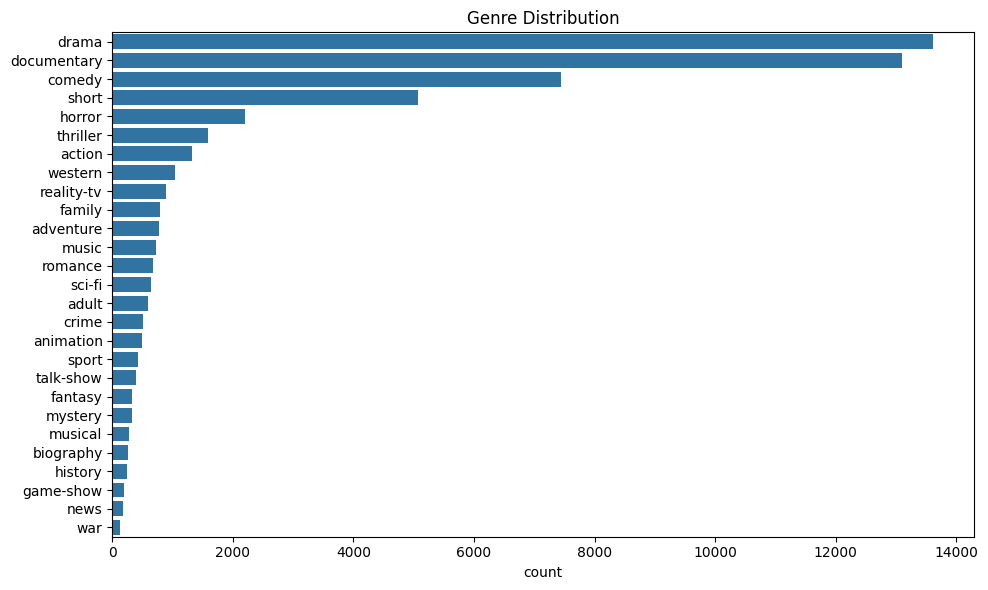

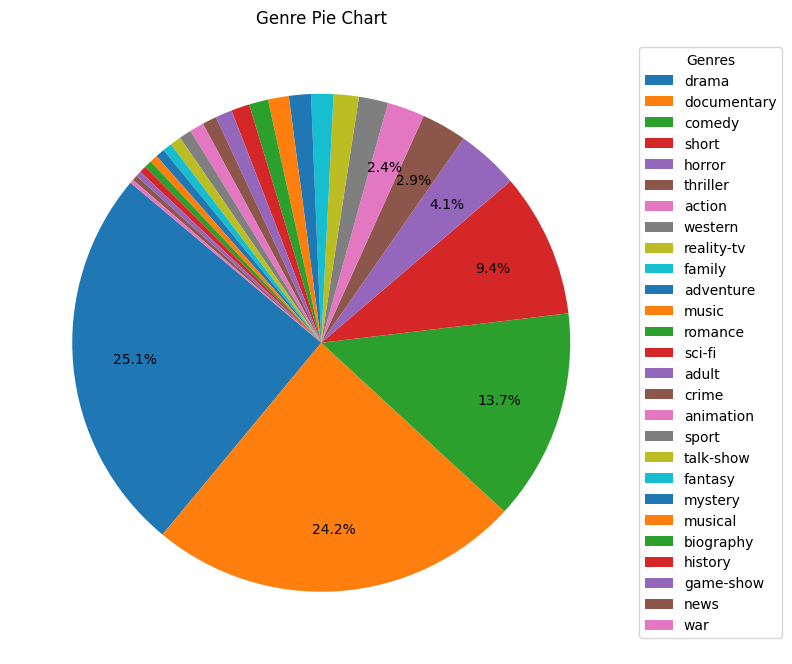

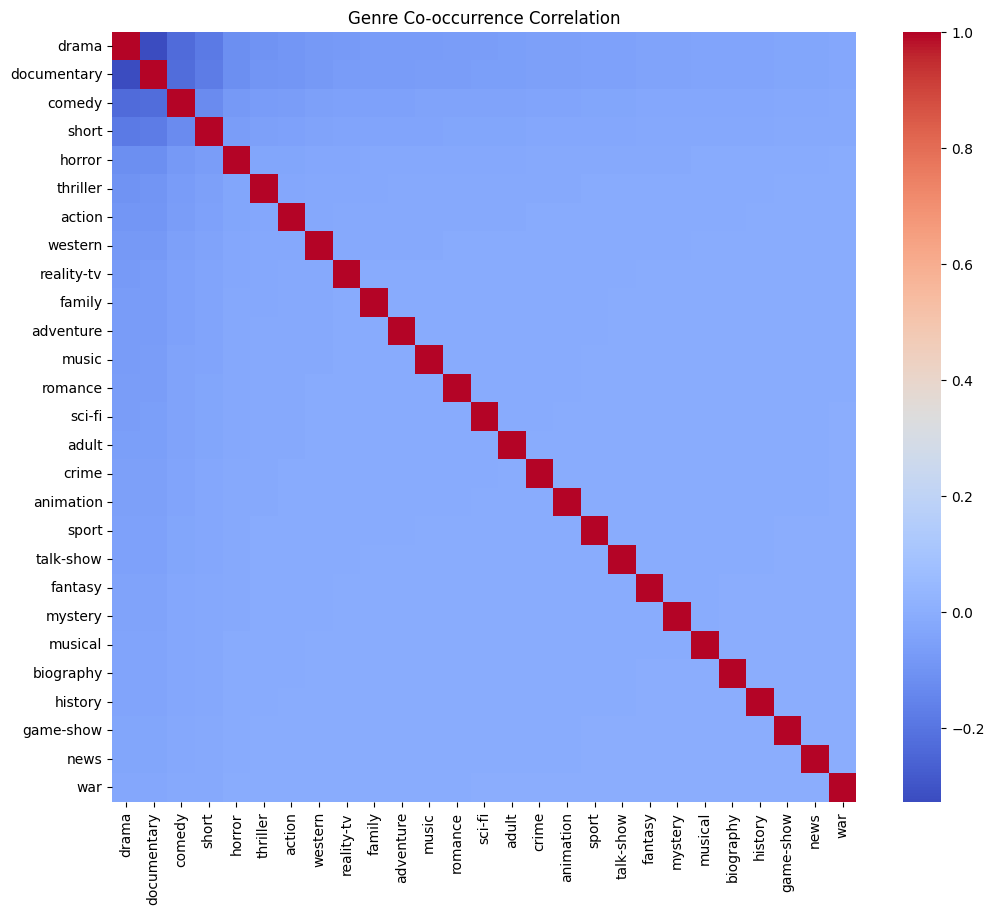

In [3]:
if VISUALIZE:
    # Genre Countplot
    plt.figure(figsize=(10,6))
    sns.countplot(y=[g for lst in df['genre_list'] for g in lst],
                  order=pd.Series([g for lst in df['genre_list'] for g in lst]).value_counts().index)
    plt.title("Genre Distribution")
    plt.tight_layout()
    plt.show()

    # Pie Chart
    sizes = all_genres.value_counts()[valid_genres]
    labels = valid_genres
    plt.figure(figsize=(8,8))
    wedges, _, autotexts = plt.pie(
        sizes,
        labels=None,
        autopct=lambda p: f'{p:.1f}%' if p>2 else '',
        startangle=140,
        pctdistance=0.75,
        textprops={'fontsize':10}
    )
    plt.legend(wedges, labels, title="Genres", loc="center left", bbox_to_anchor=(1,0,0.5,1))
    plt.title("Genre Pie Chart")
    plt.tight_layout()
    plt.show()

    # Co-occurrence Heatmap
    corr_matrix = np.corrcoef(Y.T)
    plt.figure(figsize=(12,10))
    sns.heatmap(corr_matrix, xticklabels=valid_genres, yticklabels=valid_genres, cmap="coolwarm")
    plt.title("Genre Co-occurrence Correlation")
    plt.show()


# Step 4: Train/Test Split

In [4]:
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

# Step 5: TF-IDF Vectorization

In [5]:
vectorizer = TfidfVectorizer(max_features=TFIDF_MAX_FEATURES, ngram_range=NGRAM_RANGE)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf = vectorizer.transform(X_val)

# Step 6: Model Training

In [6]:
clf = OneVsRestClassifier(LogisticRegression(solver='liblinear', max_iter=500))
clf.fit(X_train_tfidf, y_train)

OneVsRestClassifier(estimator=LogisticRegression(max_iter=500,
                                                 solver='liblinear'))

# Step 7: Validation Metrics

In [7]:
y_pred = clf.predict(X_val_tfidf)
f1 = f1_score(y_val, y_pred, average='samples')
prec = precision_score(y_val, y_pred, average='samples')
rec = recall_score(y_val, y_pred, average='samples')
print(f"\nValidation Metrics:\nF1 Score: {f1:.4f} | Precision: {prec:.4f} | Recall: {rec:.4f}")


Validation Metrics:
F1 Score: 0.3520 | Precision: 0.3513 | Recall: 0.3534


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Step 8: Prediction Function with Visualization

In [8]:
def predict_movie(texts, top_k=TOP_K_GENRES, threshold=0.5, visualize=VISUALIZE):
    texts = [preprocess_text(t) for t in texts]
    X_test_tfidf = vectorizer.transform(texts)
    probs = clf.predict_proba(X_test_tfidf)
    results = []
    for i, row in enumerate(probs):
        top_idx = row.argsort()[-top_k:][::-1]
        genres = [mlb.classes_[j] for j in top_idx if row[j]>=threshold]
        results.append(genres)
        if visualize and genres:
            plt.figure(figsize=(6,3))
            plt.bar(genres, row[top_idx[:len(genres)]])
            plt.title(f"Top Genres for Movie {i+1}")
            plt.ylim(0,1)
            plt.show()
    return results

# Step 9: Test Examples


Example Predictions:


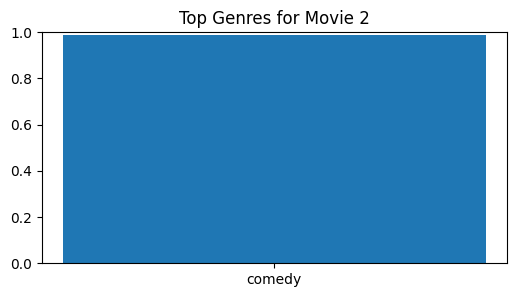

Movie 1 predicted genres: []
Movie 2 predicted genres: ['comedy']


In [9]:
sample_texts = [
    "A superhero fights aliens to save the world.",
    "A romantic comedy about two friends falling in love."
]

print("\nExample Predictions:")
predicted_genres = predict_movie(sample_texts)
for i, g in enumerate(predicted_genres):
    print(f"Movie {i+1} predicted genres: {g}")

# Step 10: Save Model & Vectorizer

In [10]:
import pickle
from pathlib import Path

OUTPUT_DIR = Path("saved_model")
OUTPUT_DIR.mkdir(exist_ok=True)

# Save TF-IDF vectorizer
with open(OUTPUT_DIR/"tfidf_vectorizer.pkl", "wb") as f:
    pickle.dump(vectorizer, f)

# Save LogisticRegression model
with open(OUTPUT_DIR/"logreg_model.pkl", "wb") as f:
    pickle.dump(clf, f)

# Save MultiLabelBinarizer
with open(OUTPUT_DIR/"mlb.pkl", "wb") as f:
    pickle.dump(mlb, f)

print("Model, vectorizer, and MLb saved to 'saved_model/' folder.")


Model, vectorizer, and MLb saved to 'saved_model/' folder.


# Step 11: Load Model (Future Use)

In [11]:
# Load TF-IDF
with open("saved_model/tfidf_vectorizer.pkl", "rb") as f:
    vectorizer_loaded = pickle.load(f)

# Load classifier
with open("saved_model/logreg_model.pkl", "rb") as f:
    clf_loaded = pickle.load(f)

# Load MultiLabelBinarizer
with open("saved_model/mlb.pkl", "rb") as f:
    mlb_loaded = pickle.load(f)

print("Model, vectorizer, and MLb loaded successfully!")


Model, vectorizer, and MLb loaded successfully!


# Step 12: Prediction with Loaded Model

In [12]:
def predict_movie_loaded(texts, top_k=3, threshold=0.5):
    texts = [re.sub(r"[^a-z\s]", " ", t.lower()).strip() for t in texts]
    X_test_tfidf = vectorizer_loaded.transform(texts)
    probs = clf_loaded.predict_proba(X_test_tfidf)
    results = []
    for row in probs:
        top_idx = row.argsort()[-top_k:][::-1]
        genres = [mlb_loaded.classes_[j] for j in top_idx if row[j]>=threshold]
        results.append(genres)
    return results

# Example
sample_texts = ["A superhero fights aliens.", "A romantic comedy about two friends."]
print(predict_movie_loaded(sample_texts))


[[], ['comedy']]
